In [1]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
import os
import sys
nb_dir = os.path.dirname(os.path.split(os.getcwd())[0])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from turicreate import SFrame, load_sframe
from pathlib import Path
import turicreate.aggregate as agg
import numpy as np

In [4]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
import ntpath
from tqdm import tqdm
from itertools import chain
import seaborn as sns
from  matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages


## Utility Functions

In [5]:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i + n]

def get_d(sf_corr):
    for data in sf_corr.groupby("Disease"):
        if len(data[1]) >5:
            yield data[1].sort_values("Year")

### To PDF

In [6]:

plt.figure(figsize=(20, 10))

sns.set(style="ticks")
def create_gird(df, col, hue,x,y,sharey=True, legend=False):

    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(df, col=col, hue=hue, palette=sns.color_palette("hls", 4),sharey=sharey,
                         col_wrap=3, height=4.5)
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

    # Draw a horizontal line to show the starting point
    grid.map(plt.axhline, y=0, ls=":", c=".5")

    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, x, y)
    if legend:
        grid.add_legend()



    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1)
    return grid

## Analysis

In [7]:
spothlight = ["SARS","MERS Coronavirus", "Avian Influenza","Ebola", "Influenza", "HIV/AIDS","Hepatitis B","Hepatitis C", "Swine Flu"]

In [8]:
diseases_id = load_sframe("Data/diseases_id.csv")
disease_names = pd.read_csv("Data/disease_names.csv")

Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/diseases_id.csv

Parsing completed. Parsed 18 lines in 0.070739 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /storage/homedir/dima/Projects/Giga/ScienceDynamics/examples/Coronavirus/Data/diseases_id.csv

Parsing completed. Parsed 18 lines in 0.071383 secs.

In [64]:
diseases_mag = load_sframe("Data/mag/diseases_med_mag.sframe")

In [65]:
diseases_mag = diseases_mag[diseases_mag["Ref Number"]>5]

#### Diseases Researchers

In [11]:
diseases_mag_authors = diseases_mag.stack("Authors List Sorted",new_column_name="author")

In [12]:
diseases_mag_authors = diseases_mag_authors[diseases_mag_authors["Year"]>2001]

In [13]:
diseases_researchers = diseases_mag_authors.groupby("disease",  { "author_count": agg.COUNT_DISTINCT("author")}).sort('author_count',ascending=False)

In [14]:
diseases_researchers = diseases_researchers.filter_by(spothlight,"disease")

In [15]:
diseases_researchers

disease,author_count
HIV/AIDS,290487
Influenza,114541
Hepatitis C,101053
Hepatitis B,84847
Swine Flu,33029
Avian Influenza,18533
Ebola,14232
SARS,12938
MERS Coronavirus,3782


New Authros Over Time (Not inclided in the papaer):

In [16]:
disease_authors = dict(zip(spothlight, [set()]*9))
res = {"Year":[],"Disease":[],"Value":[],"Type":[]}
for year in tqdm(range(2002,2019)):
    for d in spothlight:
        author_list = diseases_mag[(diseases_mag["disease"]==d)&(diseases_mag["Year"]==year)&(diseases_mag["Authors List Sorted"]!=None)]["Authors List Sorted"]
        author_list = set(chain(*author_list))
        res["Year"].append(year)
        res["Disease"].append(d)
        res["Type"].append("New Authors")
        res["Value"].append(len(author_list-disease_authors[d]))
        res["Year"].append(year)
        res["Disease"].append(d)
        res["Type"].append("Distinct Authors")
        res["Value"].append(len(author_list))
        disease_authors[d] = disease_authors[d]|author_list

100%|██████████| 17/17 [00:15<00:00,  1.06it/s]


In [17]:
new_authors = pd.DataFrame(res)

In [18]:
new_authors = new_authors.sort_values(["Disease", "Year"])

Not in the paper


<Figure size 1440x720 with 0 Axes>

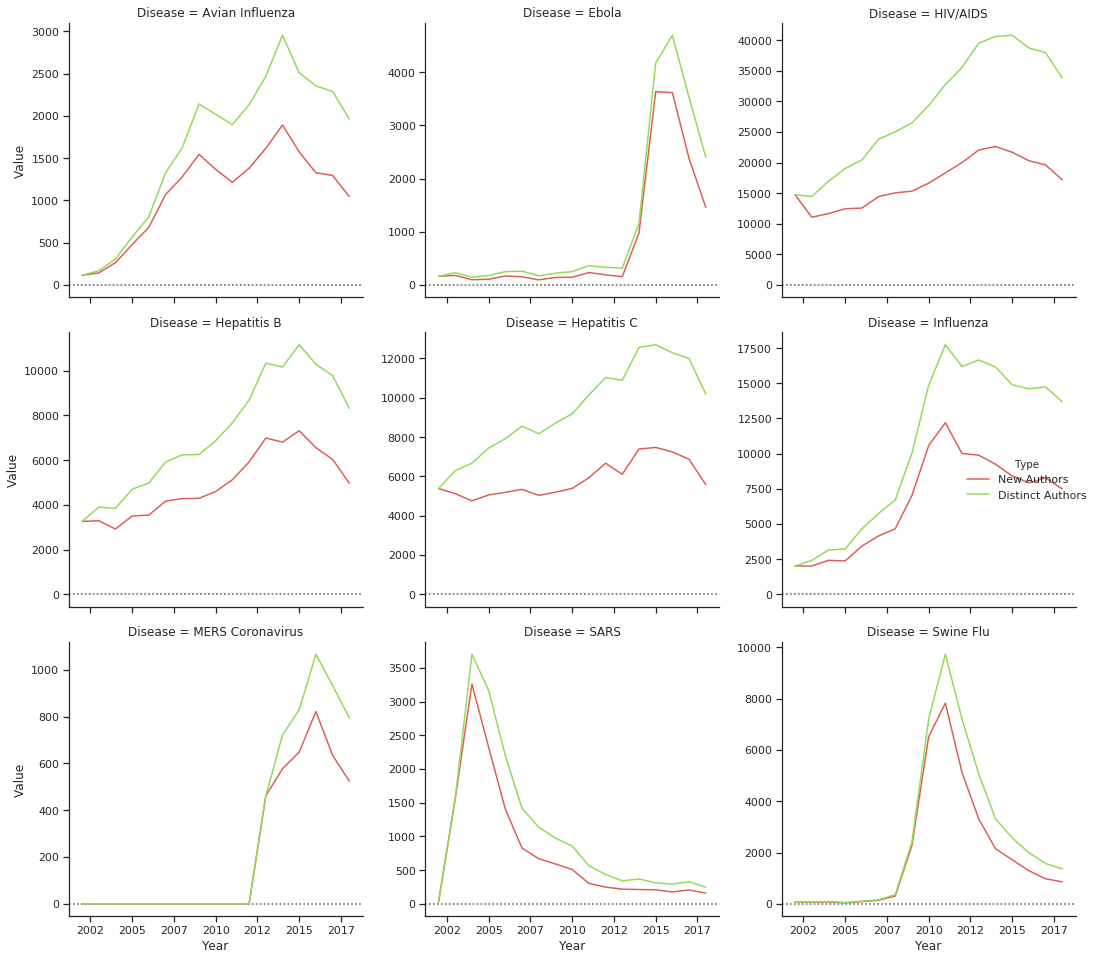

In [89]:


plt.rc('text', usetex=False)
plt.figure(figsize=(20, 10))
create_gird(new_authors,"Disease","Type","Year", "Value",False, legend=True)
#         plt.title('Page')
# plt.savefig("output/Collab/new_authors.png")
# plt.close()



In [21]:
autor_disease =  diseases_mag[(diseases_mag["Year"]>2001)&(diseases_mag["Ref Number"] >5)][["PaperId","disease","Authors List Sorted"]].stack("Authors List Sorted",new_column_name="Author")

In [22]:
autor_disease = autor_disease.filter_by(spothlight, "disease")

In [23]:
autor_disease_count = autor_disease.groupby(["disease", "Author"], {"Count":agg.COUNT()})

Average Number of Papers for each author on a specific disease:

In [62]:
autor_disease_count.to_dataframe()[["disease","Count"]].groupby("disease").mean()


,Count
disease,
Avian Influenza,1.987859
Ebola,1.831155
HIV/AIDS,2.597497
Hepatitis B,1.858604
Hepatitis C,2.199202
Influenza,2.222619
MERS Coronavirus,1.804865
SARS,1.799583
Swine Flu,1.619879


Average Number of Papers for authors with more than one paper on a specific disease:

In [86]:
mutli_papaers = autor_disease_count[autor_disease_count["Count"]>1].to_dataframe()[["disease","Count"]].groupby("disease").mean()
mutli_papaers

,Count
disease,
Avian Influenza,4.502583
Ebola,4.105540
HIV/AIDS,6.402864
Hepatitis B,4.443468
Hepatitis C,5.266106
Influenza,5.080538
MERS Coronavirus,3.850187
SARS,3.893706
Swine Flu,3.471810


In [88]:
mutli_papaers.loc["HIV/AIDS"] - mutli_papaers.loc["SARS"]

Count    2.509158
dtype: float64

In [33]:
from ScienceDynamics.datasets.microsoft_academic_graph import MicrosoftAcademicGraph
from ScienceDynamics.config.configs import DATASETS_BASE_DIR
mag = MicrosoftAcademicGraph(DATASETS_BASE_DIR)

In [34]:
diseases_mag_authors = diseases_mag_authors.filter_by(spothlight,"disease")

In [35]:
diseases_authors = diseases_mag.stack("Authors List Sorted",new_column_name="author")

In [36]:
authors = set(diseases_mag_authors["author"])

In [37]:
extended_papers = mag.extended_papers.stack("Authors List Sorted",new_column_name="author")

In [38]:
authors_papers = extended_papers.filter_by(list(authors),"author")

In [39]:
author_first_paper = authors_papers.groupby("author",{"Year":agg.MIN("Year")})

In [40]:
diseases_mag_authors = diseases_mag_authors.join(author_first_paper,on="author")

In [41]:
diseases_mag_authors["seniority when published"] = diseases_mag_authors["Year"] - diseases_mag_authors["Year.1"]

General Seniority:

In [42]:
diseases_mag_authors.groupby("disease", {"seniority":agg.AVG("seniority when published"), "median":agg.QUANTILE("seniority when published", [0.5])})

disease,seniority,median
Ebola,9.732013353286513,[5.0]
Hepatitis B,9.514714927994808,[5.0]
Hepatitis C,11.526719343400682,[8.0]
HIV/AIDS,10.967773700232865,[7.0]
Avian Influenza,8.479465812545822,[5.0]
Swine Flu,9.332280432872889,[5.0]
SARS,8.37916076107031,[4.0]
Influenza,10.253176788527002,[6.0]
MERS Coronavirus,10.479490184588343,[7.0]


In [66]:
diseases_mag["FirstAuthor"] = diseases_mag["Authors List Sorted"].apply(lambda x: x[0])

In [67]:
diseases_mag["LastAuthor"] = diseases_mag["Authors List Sorted"].apply(lambda x: x[-1])

In [68]:
diseases_mag = diseases_mag.filter_by(spothlight,"disease")

In [69]:
diseases_mag = diseases_mag.join(author_first_paper,on={"FirstAuthor": "author"},alter_name={"Year":"FirstYear"})

In [70]:
diseases_mag = diseases_mag.join(author_first_paper,on={"LastAuthor": "author"},alter_name={"Year":"LastYear"})

In [74]:
diseases_mag["First author seniority when published"] = diseases_mag["Year"] - diseases_mag["FirstYear"]

In [77]:
diseases_mag["Last author seniority when published"] = diseases_mag["Year"] - diseases_mag["LastYear"]

In [79]:
diseases_mag.groupby("disease", {"seniority first":agg.AVG("First author seniority when published"), "median first":agg.QUANTILE("First author seniority when published", [0.5]), "seniority last":agg.AVG("Last author seniority when published"), "median last":agg.QUANTILE("Last author seniority when published", [0.5])})

disease,seniority first,median first,seniority last,median last
Ebola,8.332463768115954,[4.0],15.662318840579712,[14.0]
Hepatitis B,7.54365847989463,[3.0],14.757805841791274,[13.0]
Hepatitis C,8.780259095761565,[5.0],17.225742231455005,[15.0]
HIV/AIDS,8.080330090894597,[4.0],15.726048477116887,[14.0]
Avian Influenza,6.864944216089253,[3.0],14.33176746917205,[12.0]
Swine Flu,7.173761825264331,[3.0],15.076516416249305,[13.0]
SARS,7.701256942414498,[3.0],14.396083016661795,[12.0]
Influenza,8.063179136913986,[4.0],16.598468384559652,[14.0]
MERS Coronavirus,8.205097087378643,[5.0],16.873786407767,[15.0]


In [54]:
res = SFrame()
for d in spothlight:
    print(d)
    sf = diseases_mag[diseases_mag["disease"]==d]
    first = sf["seniority when published"].value_counts()[:10]
    res = res.add_columns(first.rename({"value":f"first {d}", "count":f"first count {d}"}))
    last = sf["seniority when published last"].value_counts()[:10]
    res = res.add_columns(last.rename({"value":f"last {d}", "count":f"last count {d}"}))
#     print("-----First------")
#     print(sf["seniority when published"].value_counts())
#     print("-----Last------")
#     print(sf["seniority when published last"].value_counts())

SARS
MERS Coronavirus
Avian Influenza
Ebola
Influenza
HIV/AIDS
Hepatitis B
Hepatitis C
Swine Flu


In [80]:
res

first SARS,first count SARS,last SARS,last count SARS,first MERS Coronavirus,first count MERSCoronavirus ...,last MERS Coronavirus
0,721,0,1055,0,126,0
14,126,1,283,23,38,1
12,116,2,241,18,33,3
15,112,3,199,16,31,2
13,112,4,163,14,28,5
11,107,5,145,15,28,6
9,98,6,141,1,27,15
20,96,7,112,20,26,7
1,95,8,100,13,25,4
7,93,9,92,12,25,9


In [70]:
disease_authors = dict(zip(spothlight, [set()]*9))
res = {"Year":[],"Disease":[],"Value":[],"Type":[]}
for year in tqdm(range(2002,2019)):
    for d in spothlight:
        author_list = diseases_mag[(diseases_mag["Disease"]==d)&(diseases_mag["Year"]==year)&(diseases_mag["Authors List Sorted"]!=None)]["Authors List Sorted"]
        author_list = set(chain(*author_list))
        res["Year"].append(year)
        res["Disease"].append(d)
        res["Type"].append("New Authors")
        res["Value"].append(len(author_list-disease_authors[d]))
        res["Year"].append(year)
        res["Disease"].append(d)
        res["Type"].append("Distinct Authors")
        res["Value"].append(len(author_list))
        disease_authors[d] = disease_authors[d]|author_list

/storage/homedir/dima/miniconda3/envs/promed/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
new_authors = pd.DataFrame(res)

In [72]:
new_authors = new_authors.sort_values(["Disease", "Year"])